<a href="https://colab.research.google.com/github/vinayak-pathak/pyprac_f/blob/master/tf_notebook_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import tensorflow as tf




In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate

In [9]:
def shallownet_sequential(width, height, depth, classes):

  # initialize the model alongwith the input shape to be
  # "channels last" ordering
  model = Sequential()
  inputShape = (height, width, depth)

  #define the first and only conv => relu layer
  model.add(Conv2D(32, (3, 3), padding = "same", input_shape = inputShape))
  model.add(Activation("relu"))

  #softmax classifier

  model.add(Flatten())
  model.add(Dense(classes))
  model.add(Activation("softmax"))

  #return the constructed network architectutre
  return model



In [10]:
## Create Functional API

## Create Functional API

In [11]:
def minigooglenet_functional(width, height, depth, classes):
  inputShape = (height, width, depth)
  chanDim = -1
  def conv_module(x, K, kX, kY, stride, chanDim, padding = "same"):
    x = Conv2D(K, (kX, kY), strides = stride, padding = padding)(x)
    x = BatchNormalization(axis = chanDim)(x)
    x = Activation("relu")(x)
    return x


  def inception_module(x, numK1x1, numK3x3, chanDim):
    # define two CONV modules, then concatenate across the 
    # channel dimension
    conv_1x1 = conv_module(x, numK1x1, 1, 1, (1, 1), chanDim)
    conv_3x3 = conv_module(x, numK3x3, 3, 3, (1, 1), chanDim)
    x = concatenate([conv_1x1, conv_3x3], axis = chanDim)

    #return the block
    return x

  def downsample_module(x, K, chanDim):
    # define the CONV module and POOl, then concatenate across the channel dimension

    conv_3x3 = conv_module(x, K, 3, 3, (2, 2), chanDim, padding = "valid")
    pool = MaxPooling2D((3, 3), strides = (2, 2))(x)
    x = concatenate([conv_3x3, pool], axis = chanDim)
    return x

    inputShape = (height, width, depth)
    chanDim = -1

  #define the model input and first CONV module
  inputs = Input(shape = inputShape)
  x = conv_module(inputs, 96, 3, 3, (1, 1), chanDim)

  #two inception modules followed by a downsample module
  x = inception_module(x, 32, 32, chanDim)
  x = inception_module(x, 32, 48, chanDim)
  x = downsample_module(x, 80, chanDim)

  #four inception modules followed by a downsample module
  x = inception_module(x, 112, 48, chanDim)
  x = inception_module(x,96, 64,chanDim )
  x = inception_module(x, 80, 80, chanDim)
  x = inception_module(x, 48, 96, chanDim)
  x = downsample_module(x, 96, chanDim)

  #two inception modules followed by global pool and dropout

  x = inception_module(x, 176, 160, chanDim)
  x = inception_module(x, 176, 160, chanDim)
  x = AveragePooling2D(7, 7)(x)
  x = Dropout(0.5)(x)

  #softmax classifier

  x = Flatten()(x)
  x = Dense(classes)(x)
  x = Activation("softmax")(x)

  #create the model
  model = Model(inputs, x, name = "minigooglenet")
  return model


Let’s look at a simple example implementing MiniVGGNet, an otherwise sequential model, but converted to a model subclass:

In [12]:
class MiniVGGNetModel(Model):
  def __init__(self, classes, chanDim = -1):
      #call thhe parent constructor
      super(MiniVGGNetModel, self).__init__()

      #initialize the layers in the first (CONV => RELU) * 2 =>POOL
      #layer set
      self.conv1A = conv2D(32, (3, 3), padding = "same")
      self.act1A = Activation("relu")
      self.bn1A = BatchNormalization(axis = chanDim)
      self.conv1B = Conv2D(32, (3, 3), padding = "same")
      self.act1B = Activation("relu")
      self.bn1B = BatchNormalization(axis = chanDim)
      self.pool1 = MaxPooling2D(pool_size = (2, 2))

      #initializing the layers in the second (CONV => RELU)*2 => POOL
      #layer set
      self.conv2A = conv2D(32, (3, 3), padding = "same")
      self.act2A = Activation("relu")
      self.bn2A = BatchNormalization(axis = chanDim)
      self.conv2B = Conv2D(32, (3, 3), padding = "same")
      self.act2B = Activation("relu")
      self.bn2B = BatchNormalization(axis = chanDim)
      self.pool2 = MaxPooling2D(pool_size = (2, 2))

      #initializing the layers in our fully-connected layer set
      self.flatten = Flatten()
      self.dense3 = Dense(512)
      self.act3 = Activation("relu")
      self.bn3 = BatchNormalization()
      self.do3 = Dropout(0.5)

      #initialize the layers in the softmax classifier layer set
      self.dense4 = Dense(classes)
      self.softmax = Activation("softmax")

  def call(self, inputs):
      #build the first (CONV =>RELU)*2 => POOL layer set
      x = self.conv1A(inputs)
      x = self.act1A(x)
      x = self.bn1A(x)
      x = self.conv1B(inputs)
      x = self.act1B(x)
      x = self.bn1B(x)
      x = self.pool1(x)

      #build the second (CONV => RELU)*2 => POOL layer set

      x = self.conv2A(x)
      x = self.act2A(x)
      x = self.bn2A(x)
      x = self.conv2B(x)
      x = self.act2B(x)
      x = self.bn2B(x)
      x = self.pool2(x)
      
      #build our FC layer set
      x = self.flatten(x)
      x = self.dense3(x)
      x = self.act3(x)
      x = self.bn3(x)
      x = self.do3(x)

      #build the softmax classifier
      x = self.dense4(x)
      x = self.softmax(x)

      # return the constructed model
      return x







# Implementing the training script

In [56]:
import matplotlib
#matplotlib.use("Agg")

import logging
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)


from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import argparse





In [16]:
#import argparse
#ap = argparse.ArgumentParser()
#ap.add_argument("-m", "--model", type = str, default = "sequential", choices = ["sequential", "functional", "class"], help = "type of model architecture" )
#ap.add_argument("-p", "--plot", type = str, required = True, help = "type of model architecture" )
#args = vars(ap.parse_args())

In [35]:
INIT_LR = 1e-2
BATCH_SIZE = 128
NUM_EPOCHS = 60

#initialize the label names for the CIFAR-10 dataset

labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

#load the CIFAR-10 dataset
print("[INFO] loading CIFAR-10 dataset...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()


[INFO] loading CIFAR-10 dataset...


In [34]:
trainY

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [36]:
#scale the data to the range [0, 1]
trainX = trainX.astype("float32")/255.0
testX = testX.astype("float32")/255.0



In [38]:
trainY

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [37]:
#convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [26]:
trainY.shape

(50000, 1)

In [27]:
testY.shape

(10000, 1)

In [ ]:
trainY.shape

In [39]:
aug = ImageDataGenerator(rotation_range = 18, zoom_range = 0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode='nearest')

In [40]:
def model_choice(c):
  if c == "sequential":
    print("[INFO] using the sequential model")
    model = shallownet_sequential(32, 32, 3, len(labelNames))

  elif c == "functional":
    print("[INFO] using the functional model")
    model = minigooglenet_functional(32, 32, 3, len(labelNames))
  elif c == "class":
    print("[INFO] using the functional model")
    model = MiniVGGNetModel(len(labelNames))

  return model



In [41]:
model = model_choice("functional")

[INFO] using the functional model


In [42]:
type(model)

tensorflow.python.keras.engine.functional.Functional

In [43]:
## Initialize the optimizer and compile the model


opt = SGD(lr = INIT_LR, momentum = 0.9, decay = INIT_LR/NUM_EPOCHS)
print("[INFO] training network...")
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

##Train the network
H = model.fit(aug.flow(trainX, trainY, batch_size=BATCH_SIZE), validation_data = (testX, testY), steps_per_epoch=trainX.shape[0]//BATCH_SIZE, epochs = NUM_EPOCHS, verbose =1)


[INFO] training network...
Epoch 1/60
390/390 [==============================] - 38s 97ms/step - loss: 1.6239 - accuracy: 0.4062 - val_loss: 1.9143 - val_accuracy: 0.3236
Epoch 2/60
390/390 [==============================] - 36s 92ms/step - loss: 1.2386 - accuracy: 0.5576 - val_loss: 1.1811 - val_accuracy: 0.5899
Epoch 3/60
390/390 [==============================] - 37s 94ms/step - loss: 1.0710 - accuracy: 0.6203 - val_loss: 1.1119 - val_accuracy: 0.6050
Epoch 4/60
390/390 [==============================] - 37s 96ms/step - loss: 0.9586 - accuracy: 0.6630 - val_loss: 0.9035 - val_accuracy: 0.6834
Epoch 5/60
390/390 [==============================] - 37s 95ms/step - loss: 0.8885 - accuracy: 0.6888 - val_loss: 1.0960 - val_accuracy: 0.6466
Epoch 6/60
390/390 [==============================] - 38s 97ms/step - loss: 0.8173 - accuracy: 0.7144 - val_loss: 1.3550 - val_accuracy: 0.6215
Epoch 7/60
390/390 [==============================] - 37s 95ms/step - loss: 0.7662 - accuracy: 0.7357 - val_l

In [45]:
print("[INFO] evaluating network")
predictions = model.predict(testX, batch_size=BATCH_SIZE)
print(predictions)

[INFO] evaluating network
[[2.5761146e-06 5.1542372e-03 4.7343042e-07 ... 3.9417732e-06
  3.0292023e-04 5.0411045e-06]
 [1.0623759e-05 3.5335077e-05 9.9663095e-13 ... 3.7605214e-12
  9.9995399e-01 6.2133081e-09]
 [1.1463874e-06 1.7172281e-02 3.4024397e-10 ... 5.7255439e-10
  9.8281640e-01 1.0145912e-05]
 ...
 [2.4264772e-08 3.5296401e-07 3.8827191e-05 ... 2.2929192e-03
  6.7895587e-07 5.7682166e-07]
 [2.0910646e-08 9.9999881e-01 1.3280413e-08 ... 2.3004179e-07
  3.8325965e-08 6.4595548e-07]
 [7.6176023e-13 1.6405001e-11 2.9410359e-12 ... 9.9999833e-01
  3.3507217e-14 3.2766101e-12]]


In [46]:
predictions

array([[2.5761146e-06, 5.1542372e-03, 4.7343042e-07, ..., 3.9417732e-06,
        3.0292023e-04, 5.0411045e-06],
       [1.0623759e-05, 3.5335077e-05, 9.9663095e-13, ..., 3.7605214e-12,
        9.9995399e-01, 6.2133081e-09],
       [1.1463874e-06, 1.7172281e-02, 3.4024397e-10, ..., 5.7255439e-10,
        9.8281640e-01, 1.0145912e-05],
       ...,
       [2.4264772e-08, 3.5296401e-07, 3.8827191e-05, ..., 2.2929192e-03,
        6.7895587e-07, 5.7682166e-07],
       [2.0910646e-08, 9.9999881e-01, 1.3280413e-08, ..., 2.3004179e-07,
        3.8325965e-08, 6.4595548e-07],
       [7.6176023e-13, 1.6405001e-11, 2.9410359e-12, ..., 9.9999833e-01,
        3.3507217e-14, 3.2766101e-12]], dtype=float32)

In [47]:
testX

array([[[[0.61960787, 0.4392157 , 0.19215687],
         [0.62352943, 0.43529412, 0.18431373],
         [0.64705884, 0.45490196, 0.2       ],
         ...,
         [0.5372549 , 0.37254903, 0.14117648],
         [0.49411765, 0.35686275, 0.14117648],
         [0.45490196, 0.33333334, 0.12941177]],

        [[0.59607846, 0.4392157 , 0.2       ],
         [0.5921569 , 0.43137255, 0.15686275],
         [0.62352943, 0.44705883, 0.1764706 ],
         ...,
         [0.53333336, 0.37254903, 0.12156863],
         [0.49019608, 0.35686275, 0.1254902 ],
         [0.46666667, 0.34509805, 0.13333334]],

        [[0.5921569 , 0.43137255, 0.18431373],
         [0.5921569 , 0.42745098, 0.12941177],
         [0.61960787, 0.43529412, 0.14117648],
         ...,
         [0.54509807, 0.38431373, 0.13333334],
         [0.50980395, 0.37254903, 0.13333334],
         [0.47058824, 0.34901962, 0.12941177]],

        ...,

        [[0.26666668, 0.4862745 , 0.69411767],
         [0.16470589, 0.39215687, 0.5803922 ]

In [48]:
testX.shape

(10000, 32, 32, 3)

In [50]:
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

              precision    recall  f1-score   support

    airplane       0.92      0.88      0.90      1000
  automobile       0.85      0.98      0.91      1000
        bird       0.92      0.80      0.85      1000
         cat       0.78      0.77      0.78      1000
        deer       0.87      0.88      0.88      1000
         dog       0.92      0.69      0.79      1000
        frog       0.86      0.94      0.90      1000
       horse       0.80      0.96      0.87      1000
        ship       0.95      0.93      0.94      1000
       truck       0.92      0.91      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



In [57]:
N = np.arange(0, NUM_EPOCHS)
title = "Training Loss and Accuracy on CIFAR-10 ({})".format("functional")

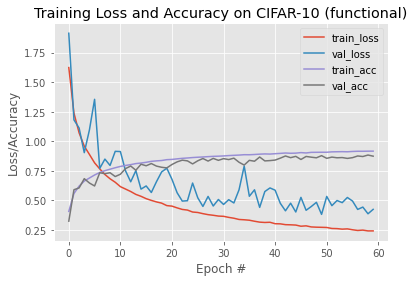

In [74]:
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title(title)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


In [65]:
plt.imshow(testX[0])
plt.show()

In [60]:
import matplotlib.pyplot as plt


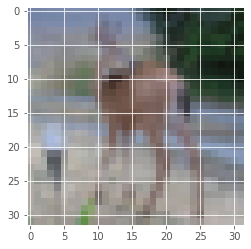

In [73]:

plt.imshow(testX[100])

In [62]:
import cv2

In [63]:
cv2.imshow(testX[0])

DisabledFunctionError: ignored